In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Sequential, Model

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

np.random.seed(12211)

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_train
%aimport help_funcs
#import help_funcs_zeropt as help_funcs
#import help_train_zeropt as help_train # Wait, when did we start doing this instead of the line profiler?
import zeropoints_new as zeropoints
import SetPub
SetPub.set_pub()

In [2]:
train_mode = True # False if you don't want to train again

In [3]:
num_train = 200000 # 10000, 4000 # Max: 200000 
num_test = 20000 # 1000 # Max: 20000

In [4]:
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6] # Soon there will be more!
# Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][3]
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7] # Test on the same things we tested before (SDSS)
surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS']

In [5]:
# one dictionary for each sim
# contains names of bands and the number (index) associated with them?
# is that a dictionary of dictionaries?
# 'des', 'irac', 'jwst', 'lsst', 'pau', 'sdss', 'spherex', wise'
des_bands = {'g-r': 0, 'r-i': 1, 'i-z': 2, 'z-y': 3, 'mag(g)': 4} # or is it mag(i)?
irac_bands = {'I2-I1': 0, 'I3-I2': 1, 'I4-I3': 2, 'mag(I1)': 3}
wise_bands = {'w2-w1': 0, 'w3-w2': 1, 'w4-w3': 2, 'mag(w1)': 3}

use_lindseys_data = True
if use_lindseys_data:
    D = 5
    D2 = 4
    sim1 = 'des'
    sim2 = 'irac'
    
    # Load training data
    train_dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Synthetic_Data/fsps_wrapper/notebooks/out/rand_z/'
    X_train1, y_train1, X_test1, y_test1 = help_train.loadTrainTest_custom_randz(Testset, sim1, train_dirIn, nbands = D, frac_train = 0.5)
    X_train2, y_train2, X_test2, y_test2 = help_train.loadTrainTest_custom_randz(Testset, sim2, train_dirIn, nbands = D2, frac_train = 0.5)
    print("Xtrain 1 and 2:")
    print(X_train1)
    print(X_train2)
    
    X_train1_subsample = np.delete(X_train1, des_bands['z-y'], axis = 1)
    X_train2_subsample = np.delete(X_train2, [irac_bands['I3-I2'], irac_bands['I4-I3']], axis = 1)
    print("Xtrain subsamples 1 and 2:")
    print(X_train1_subsample)
    print(X_train2_subsample)
    
    print("Making a new band")
    new_band = np.array([X_train1_subsample[:,-1] - X_train2_subsample[:,-1]]).T
    print(new_band)
    
    # Clean up dictionary and dimensions
    # (How to make this actually fix the dictionary?)
    del des_bands['z-y']
    del irac_bands['I3-I2']
    del irac_bands['I4-I3']
    D = len(list(des_bands))
    D2 = len(list(irac_bands))
    D_tot = D + D2
    
    X_train = np.concatenate((X_train1_subsample, X_train2_subsample, new_band), axis = 1)
    print("Xtrain total")
    print(X_train)
    y_train = np.concatenate((y_train1, y_train2))
    print(y_train)
    
    # Load testing data
    print("Testing on Lindsey's data")
    X_test = np.load('/data/a/cpac/nramachandra/Projects/phoZ/SurveyTrain/TestingDataLindsey/magi_selected_des_irac.npy')
    y_test = np.load('/data/a/cpac/nramachandra/Projects/phoZ/SurveyTrain/TestingDataLindsey/magi_selected_des_irac_z.npy')
    print("Xtest:\n", X_test)
    print("ytest:\n", y_test)

else:
    combine = True
    if combine:
        D = 4
        sim1 = 'wise' # 'des', 'irac', 'jwst', 'lsst', 'pau', 'sdss', 'spherex', wise'
        sim2 = 'des'
        #train_dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Synthetic_Data/fsps_wrapper/notebooks/out/'
        train_dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Synthetic_Data/fsps_wrapper/notebooks/out/rand_z/'
        X_train1, y_train1, X_test1, y_test1 = help_train.loadTrainTest_custom_randz(Testset, sim1, train_dirIn, nbands = D, frac_train = 0.5)
        X_train2, y_train2, X_test2, y_test2 = help_train.loadTrainTest_custom_randz(Testset, sim2, train_dirIn, nbands = D, frac_train = 0.5)
        X_train = np.concatenate((X_train1, X_train2), axis = 1)
        print("Xtrain:\n", X_train)
        y_train = np.concatenate((y_train1, y_train2))
        X_test = np.concatenate((X_test1, X_test2), axis = 1)
        #print(np.array_equal(y_test1, y_test2))
        y_test = y_test1 # They should both be identical
    else:
        D = 4
        sim = 'wise' # 'des', 'irac', 'jwst', 'lsst', 'pau', 'sdss', 'spherex', wise'
        #train_dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Synthetic_Data/fsps_wrapper/notebooks/out/'
        train_dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Synthetic_Data/fsps_wrapper/notebooks/out/rand_z/'
        test_dirIn = '/data/a/cpac/aurora/MDN_phoZ/Data/fromGalaxev/photozs/datasets/data_feb_2021/'
        X_train, y_train, X_test, y_test = help_train.loadTrainTest_custom_randz(Testset, sim, train_dirIn, nbands = D, frac_train = 0.5)
        #X_train, y_train, X_test, y_test = help_train.loadTrainTest_custom_randz(Testset, sim, train_dirIn, frac_train = 0.5) # Need X_err and test_labels
    D = X_train.shape[1]
    print(D)

Training on sim:  des
X training data shape:  (2000000, 5)
y training data shape:  (2000000,)
Training on sim:  irac
X training data shape:  (2000000, 4)
y training data shape:  (2000000,)
Xtrain 1 and 2:
[[1.766e-01 1.153e-01 1.368e-01 7.035e-02 2.579e+01]
 [6.207e-01 2.892e-01 2.173e-01 8.828e-02 1.653e+01]
 [4.789e-01 2.422e-01 3.216e-01 1.125e-01 2.346e+01]
 ...
 [2.705e-01 5.075e-01 5.449e-01 5.476e-02 2.464e+01]
 [4.847e-01 5.370e-01 1.171e-01 6.816e-02 2.390e+01]
 [2.528e-01 6.319e-01 1.756e-01 2.398e-02 2.369e+01]]
[[ 0.062 -0.226 -0.563 24.024]
 [-0.493 -0.456 -0.55  16.035]
 [ 0.108 -0.042 -0.475 20.483]
 ...
 [-0.286 -0.426 -0.459 22.95 ]
 [-0.448 -0.29  -0.611 22.409]
 [-0.396 -0.319 -0.543 22.225]]
Xtrain subsamples 1 and 2:
[[ 0.177  0.115  0.137 25.794]
 [ 0.621  0.289  0.217 16.527]
 [ 0.479  0.242  0.322 23.455]
 ...
 [ 0.27   0.508  0.545 24.643]
 [ 0.485  0.537  0.117 23.904]
 [ 0.253  0.632  0.176 23.69 ]]
[[ 0.062 24.024]
 [-0.493 16.035]
 [ 0.108 20.483]
 ...
 [-0

In [6]:
# Hyperparameters
prtb = False
if prtb:
    D = D - 1 #6  # number of features (in input space)
    K = 3 #16 # number of mixture components # a "component" of a GMM is one gaussian, right?
else:
    D = D #5
    K = 3
    
n_epochs = 20 # 100
learning_rate = 1e-4
decay_rate= 1e-2
batch_size = 256

# Here we define hyperparameters!
save_mod = '/data/a/cpac/aurora/MDN_phoZ/saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [7]:
# Old version
#train_dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Data/fromGalaxev/photozs/datasets/data_july_2020/'
#test_dirIn = '/data/a/cpac/aurora/MDN_phoZ/Data/fromGalaxev/photozs/datasets/data_feb_2021/'
#X_train, y_train, _, _ = help_train.loadTrainTest_july(train_dirIn)
#X_test, y_test, X_err, label_test = help_train.loadTest(Testset, dirIn = test_dirIn) # data_feb_2021

In [8]:
X_train, y_train, X_trainShuffleOrder = help_train.shuffle(X_train, y_train) # literally just shuffle the data
# X_test, y_test, label_test, X_testShuffleOrder = shuffleOBS(X_test, y_test, test_labels) # Why aren't we doing this?

In [9]:
minmax = False
if minmax == True:
    min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5 # Same as what we got from print_limits
    max_col = [ 3.825315,  2.8303378,  1.6937237,  1.5019817] #3.4 #5
    min_mag = 12
    max_mag = 23
    min_z = 0.0 #np.min(y_train)
    max_z = 1.1 #np.max(y_train)

    mins_and_maxs = [min_col, max_col, min_mag, max_mag, min_z, max_z]

    X_test, y_test, mask_cond = help_train.minmax_cuts(X_test, y_test, mins_and_maxs) # This is where label_test should eventually crop up

    #X_test, X_err, y_test, label_test, mask_cond = help_train.minmax_cutsOBSarr(X_test, X_err, y_test, label_test, mins_and_maxs) # Make sure all our data falls within the desired range (and bins)

In [10]:
if prtb:
    band_n = 0 # remove the u band
    approach = 'e'
    X_train = help_funcs.perturb(X_train, band_n, approach = approach)
    X_test = help_funcs.perturb(X_test, band_n, approach = approach)
    X_err = help_funcs.perturb(X_err, band_n, approach = approach)
    suffix = '_perturbed'
#     X_train = prtb_X_train
#     X_test = prtb_X_test
#     X_err = prtb_X_err
else:
    suffix = ""
#     X_train = X_train
#     X_test = X_test
#     X_err = X_err

In [11]:
# Notice, this cell is recursive. (If you run it multiple times, the resulting plot will change)
resampleTrain = False
n_bins = 200 
select_per_bin = 400 # 500, 50

if resampleTrain:
    X_train, y_train, resampled_ind = help_train.resample(X_train, y_train, n_bins, select_per_bin) # What is "rest"? And where did the original data go?

In [12]:
print("Size of features in training data: {}".format(X_train.shape)) # what do we mean features?
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (1000000, 7)
Size of output in training data: (1000000,)
Size of features in test data: (487251, 6)
Size of output in test data: (487251,)


In [16]:
# Previously, we said "this notebook doesn't train models, it deploys them"
# Now, we are training models

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

# This preproc stuff is related to "scaling routine" -- right? Yes :)
preproc = Pipeline([('stdscaler', StandardScaler())]) # This preproc tool is what allows us to transform inputs into min-max space (and therefore to feed it to the trained model)
# preproc = Pipeline([('stdscaler', MinMaxScaler())])
X_train = preproc.fit_transform(X_train) # Not sure how "fit_transform" is different from the original "transform"?

scalerfile = save_mod + '_scaling_X'
pickle.dump(preproc, open(scalerfile, 'wb'))
preproc = pickle.load(open(scalerfile, 'rb'))

X_test = preproc.transform(X_test) # This transformation puts our input into min-max space

# preproc_y = Pipeline([('stdscaler', StandardScaler())])
preproc_y = Pipeline([('stdscaler', MinMaxScaler())])

y_train = preproc_y.fit_transform(y_train.reshape(-1, 1))

scalerfile = save_mod + '_scaling_y'
pickle.dump(preproc_y, open(scalerfile, 'wb'))
preproc_y = pickle.load(open(scalerfile, 'rb'))

y_test = preproc_y.transform(y_test.reshape(-1, 1))

In [17]:
help_train.print_limits(X_train, y_train)

help_train.print_limits(X_test, y_test)

----------
number of datapoints:  2000000
z-minmax:  0.0 1.0
ColMag-min:  [-1.471 -1.561 -1.654 -4.151 -2.237 -3.435]
ColMag-max:  [5.057 4.525 3.592 2.432 1.667 2.648]
----------
----------
number of datapoints:  487251
z-minmax:  -0.006522012194860144 2.0227606105434313
ColMag-min:  [ -20.026  -28.819  -53.125   -2.473 -778.014  -36.054]
ColMag-max:  [ 29.343  27.758  43.761   4.283 758.184   4.175]
----------


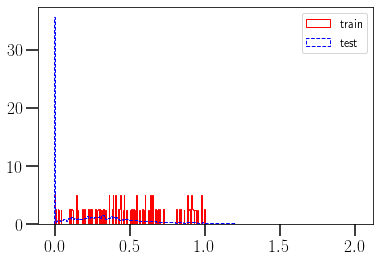

In [18]:
# That is a very messy histogram :P Looks like the precision on test is much lower than on train?
plt.figure(23)

plt.hist(y_train, density=True, bins = 250, histtype='step', label='train')
plt.hist(y_test, density=True, bins = 250, histtype='step', label='test')
plt.legend()
plt.savefig("precision" + str(num_train) + ".png")

In [19]:
def decay(epoch):
    if (epoch < 1):
        return learning_rate
    else:
        return learning_rate*(1.0/(1.0+decay_rate*(epoch)))

In [20]:
class PrintLR(tf.keras.callbacks.Callback): # Print learning rate at every epoch
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model_train.optimizer.lr.numpy()))

In [21]:
#from help_train import decay as decay
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [22]:
# These are the network parameters!! (This whole cell is network architecture)

# x = tf.keras.layers.InputLayer(input_shape=(D,)),
non_lin_act = tf.nn.relu #tf.nn.tanh
y_true = tf.keras.Input(shape=(1,))
inputs = tf.keras.Input(shape=(D,))
layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)

In [23]:
model_train = Model([inputs, y_true], [mu, var, pi], name='mdn') # Previously, this was the mixed density model (is that the same as a Gaussian mixture model?)

In [24]:
# Define custom loss
def custom_loss(layer):
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true, mu, var, pi):
        mixture_distribution = tfp.distributions.Categorical(probs=pi)
        distribution = tfp.distributions.Normal(loc=mu, scale=var)
        likelihood = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture_distribution,components_distribution=distribution)

        log_likelihood = -1.0*likelihood.log_prob(tf.transpose(y_true)) # A little confusing (talk later)
        mean_loss = tf.reduce_mean(log_likelihood)

        return mean_loss
    return loss
    
model_train.add_loss(custom_loss(inputs)(y_true, mu, var, pi))
model_train.compile(optimizer='Nadam')
model_train.summary()

Model: "mdn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          3072        input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         525312      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         2099200     dense_1[0][0]                    
________________________________________________________________________________________________

In [31]:
learning_rate

0.0001

### Perturb or remove bands

In [29]:
if prtb:
    band_n = 0 # remove the u band
    approach = 'e'
    prtb_X_train = help_funcs.perturb(X_train, band_n, approach = approach)
    prtb_X_test = help_funcs.perturb(X_test, band_n, approach = approach) # Should this be this way? What if I want to perturb for the testing too?
    prtb_X_err = help_funcs.perturb(X_err, band_n, approach = approach)
    suffix = '_perturbed'
    my_X_train = prtb_X_train
    my_X_test = prtb_X_test
    my_X_err = prtb_X_err
else:
    suffix = ""
    my_X_train = X_train
    my_X_test = X_test
    #my_X_err = X_err

### Train!

In [30]:
%%time
if train_mode:

    history = model_train.fit([my_X_train, y_train], validation_split = 0.1, epochs=n_epochs, batch_size = batch_size, callbacks=callbacks) # What's this history about?
    # The problem is in the above line
    model_train.save_weights(save_mod + '.h5')
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs', fontsize = 28)
    plt.ylabel('Loss', fontsize = 28)
    
    # Fancy legend
    fake_lines = [plt.plot([], [], c = "black")[0] for i in range(0,10)]
    param_labels = ["num train: " + str(num_train), "num test: " + str(num_test), "n epochs: " + str(n_epochs), "D: " + str(D), "K: " + str(K), "learning rate" + str(learning_rate), "decay rate: " + str(decay_rate), "batch size: " + str(batch_size), "n bins: " + str(n_bins), "select per bin: " + str(select_per_bin)]
    plt.legend(handles = fake_lines, labels = param_labels, loc = "upper right")
    if prtb:
        plt.title("Perturbed")
    plt.savefig("/data/a/cpac/aurora/MDN_phoZ/training_plots/" + sim + "_loss_epochs_ntrain" + str(num_train) + "_ntest" + str(num_test) + "_nepochs" + str(n_epochs) + "_D" + str(D) + "_K" + str(K) + "_lr" + str(learning_rate) + "_dr" + str(decay_rate) + "_bs" + str(batch_size) + "_re" + str(resampleTrain) + "_nbins" + str(n_bins) + "_spb" + str(select_per_bin) + suffix + ".png")

Epoch 1/20


ValueError: in user code:

    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer mdn: expected shape=(None, 5), found shape=(None, 6)


In [25]:
model_train.load_weights(save_mod + '.h5') # Previously, this exact line was loading the weights of (from?) the mixed density model

Now that we've trained the model, we need to apply the zero pt correction

Also, if we want to remove any bands, that has to happen here, right after we loaded the model. Because otherwise the rescaling won't work well.

In [26]:
def prediction(X_test, save_mod, surveystring, model_train, preproc, preproc_y):
    f_real = X_test.copy()
    f_real[:,:4] = f_real[:,:4]
    f_real = preproc.transform(f_real)
    y_pred = np.array(model_train(  [f_real, np.zeros(shape = f_real.shape[0]) ] ))
    y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
    y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
    y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))
    y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :]) # pretty sure this is the same as y_pred_std.reshape(-1, 1)[:, 0]??
    y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))
    y_pred_3weights = y_pred[2, :, :]
    predstdweights = np.array([y_pred_3means, y_pred_3std, y_pred_3weights]) # Should I be returning this?    
    return y_pred_3means, y_pred_3std, y_pred_3weights, y_pred_arg, y_pred_mean, y_pred_std # photo_z, photo_z_err

In [24]:
def Nesar_prediction_zp_all(X_test, label_test, save_mod, surveystring, model_train, preproc, preproc_y):
    xzero = np.zeros_like(X_test[:,:4])
    xzero[label_test == 0] = np.loadtxt(save_mod + '_xzero_' + surveystring[0])
    xzero[label_test == 1] = np.loadtxt(save_mod + '_xzero_' + surveystring[1])
    xzero[label_test == 2] = np.loadtxt(save_mod + '_xzero_' + surveystring[2])
    f_real = X_test.copy()
    f_real[:,:4] = f_real[:,:4] + xzero
    f_real = preproc.transform(f_real)
    y_pred = np.array(model_train(  [f_real, np.zeros(shape = f_real.shape[0]) ] ))
    #y_pred = np.array(model_train(f_real)) # Apparently this won't work anymore? We now need two inputs...
    y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
    y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
    y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))
    # This is exactly the same as what Nesar does in his notebook
    # But, it's randomly not what we will actually use for plotting?? That's `y_pred_mean` and the like, which we aren't calculating here
    y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :])
    y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))
    y_pred_3weights = y_pred[2, :, :]
    return y_pred_3means, y_pred_3std, y_pred_3weights, y_pred_arg, y_pred_mean, y_pred_std, xzero

In [ ]:
# VERSION 1: CORRECT ZPs
y_pred_3means, y_pred_3std, y_pred_3weights, y_pred_arg, y_pred_mean, y_pred_std, xzero = Nesar_prediction_zp_all(X_test, label_test, save_mod, surveystring, model_train, preproc, preproc_y)
y_test_all = preproc_y.inverse_transform(y_test) # why "all"?

predstdweights = np.array([y_pred_3means, y_pred_3std, y_pred_3weights])
truelabel = np.array([y_test_all[:, 0], label_test])

np.save(save_mod+'test_true', predstdweights )
np.save(save_mod+'test_pred', truelabel )

In [27]:
# VERSION 2: DON'T CORRECT ZPs
# y_pred = np.array(model_train(X_test))
idx = np.arange(len(X_test))
np.random.seed(0)
random_idx = np.random.choice(idx, 1000, replace = False) # Why are we doing this again?
y_pred = np.array(model_train(  [X_test[random_idx], np.zeros(shape = X_test[random_idx].shape[0]) ] ))
y_test = y_test[random_idx]
X_test = X_test[random_idx]

y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))
# This is all the same as prediction_zp, but isn't included in Nesar's (previous) version

# These are the same (I think?) as what we calculate in Nesar's version of prediction_zp
y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :]) # Previously, we used preproc_y to pick the best Gaussian (of the three that make up the Gaussian mixture model)
y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))
y_pred_3weights = y_pred[2, :, :]

y_test_all = preproc_y.inverse_transform(y_test)

predstdweights = np.array([y_pred_3means, y_pred_3std, y_pred_3weights])
#truelabel = np.array([y_test_all[:, 0], label_test])
np.save(save_mod+'test_true', predstdweights )
#np.save(save_mod+'test_pred', truelabel )

ValueError: Input 0 is incompatible with layer mdn: expected shape=(None, 5), found shape=(1000, 6)

(1000,)
(1000,)


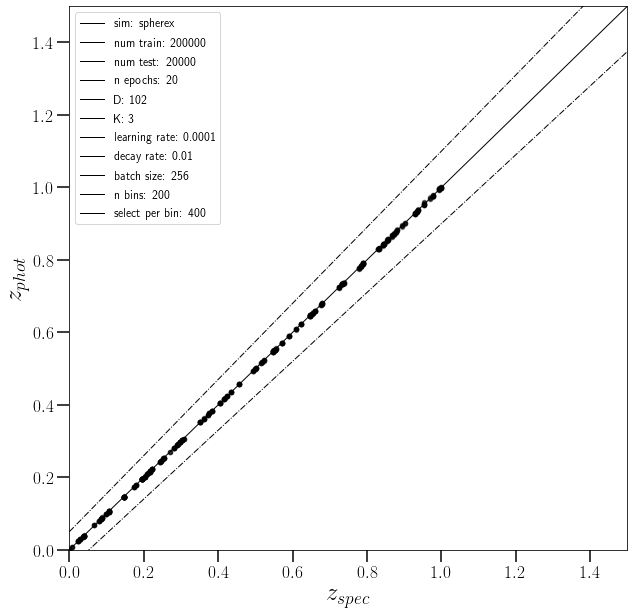

<Figure size 432x288 with 0 Axes>

In [53]:
ifPlotWeighted = True
y_pred_mean_best = y_pred_mean # why are we using y_pred_mean and not y_pred_3means?
y_pred_std_best = y_pred_std   

fig, ax = plt.subplots(figsize=(10, 10,)) # How does this work (or conflict) with plt.figure() down below?
if ifPlotWeighted:

    colorstring = ['b', 'r', 'g', 'k', 'orange']
    #surveystring = ['SDSS', 'VIPERS', 'DEEP2']

    plt.figure(22)#, figsize=(10, 10,))

    C = 0.05
    z_t = np.array([0, 3])
    z_tp = z_t + C*(1+z_t)
    z_tm = z_t - C*(1+z_t)

    ax.plot(z_t, z_t, 'k')
    ax.plot(z_t, z_tp, 'k-.')
    ax.plot(z_t, z_tm, 'k-.')
    
    offset = 0.0 # What is the point of this?

    print(preproc_y.inverse_transform(y_test)[:, 0].shape)
    print(preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[:, 0].shape)
    
    ax.errorbar(preproc_y.inverse_transform(y_test)[:, 0], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[:, 0], yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[:, 0], fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+sim, c = 'k')
    
    #for label_ind in [0, 1, 2]:
    #    surveyindx = np.where(label_test == label_ind)
    #    offset = 0.0

    #    ax.errorbar(preproc_y.inverse_transform(y_test)[surveyindx][:, 0], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0], yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0], fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind], c = colorstring[label_ind])

ax.set_ylabel(r'$z_{phot}$', fontsize=25)
ax.set_xlabel(r'$z_{spec}$', fontsize=25)

ax.set_xlim(0.0, 3)
ax.set_ylim(0.0, 3)

plt.tight_layout()
# plt.axes().set_aspect('equal')

#leg1 = ax.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)
fake_lines = [ax.plot([], [], c = "black", linestyle = '-')[0] for i in range(0,11)]
param_labels = ["sim: " + sim, "num train: " + str(num_train), "num test: " + str(num_test), "n epochs: " + str(n_epochs), "D: " + str(D), "K: " + str(K), "learning rate: " + str(learning_rate), "decay rate: " + str(decay_rate), "batch size: " + str(batch_size), "n bins: " + str(n_bins), "select per bin: " + str(select_per_bin)]
ax.legend(handles = fake_lines, labels = param_labels, loc = "upper left")
if prtb:
    ax.set_title("Perturbed")
#ax.add_artist(leg1)
##fig.savefig('phoz_compare_surveys_numtrain_' + str(num_train) + '.pdf', bbox_inches='tight')
fig.savefig("/data/a/cpac/aurora/MDN_phoZ/training_plots/" + sim + "phoz_ntrain" + str(num_train) + "_ntest" + str(num_test) + "_nepochs" + str(n_epochs) + "_D" + str(D) + "_K" + str(K) + "_lr" + str(learning_rate) + "_dr" + str(decay_rate) + "_bs" + str(batch_size) + "_re" + str(resampleTrain) + "_nbins" + str(n_bins) + "_spb" + str(select_per_bin) + suffix + ".png")
#fig.savefig("training_plots/zp_anti-attempt.png")
fig.show()
# num train, num test, n epochs, D, K, learning rate, decay rate, batch size, nbins, select per bin

In [ ]:
print(num_test)

In [ ]:
# Plot a pdf
from scipy import stats
nrows = 3
#fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(8, nrows*3), num='pdfs')
fig, axes = help_funcs.plot_pdfs(y_pred_3means, y_pred_3weights, y_pred_3std, y_test_all, num_train = num_train, num_test = num_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
# fig.savefig("quick_pdfs.png")

## Sigma_NMAD, OutFrac

In [30]:
sigmaNMAD = help_funcs.sigmaNMAD(y_test.T[0], y_pred_mean)
outFrac = help_funcs.outlierFrac(y_test.T[0], y_pred_mean, threshold = 0.15)
print(sigmaNMAD)
print(outFrac)

(1000,)
0.005501166089856722
13.8


In [45]:
sigmaNMAD_array, outFr_array, bins = help_funcs.validate(y_test.T[0], y_pred_mean) # Why is y_test in a weird shape before I do this?
print(sigmaNMAD_array)
print(outFr_array) # Should those 0's really be zeros?

[0.005 0.004 0.005 0.004 0.    0.032 0.    0.001 0.008 0.003 0.004 0.
 0.005 0.102 0.003 0.058 0.    0.011 0.009 0.   ]
[58.586  0.    21.935  6.557  0.    35.135  0.     0.    11.111  0.
  0.     0.     0.    53.333  0.     5.882  0.     0.     4.724  0.   ]


length zero for bin  6
length zero for bin  11
length zero for bin  12
length zero for bin  13
length zero for bin  14


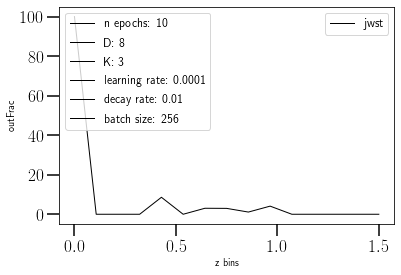

In [98]:
# Perturb lots of bands (approach b, c, or d) AFTER training
ncol = 3 # Should this actually be vertical and outside the plots, perhaps?
metric_name = "outFrac"

fig, ax = plt.subplots(1, 1, sharex = True)
band_names = ["u-g", "g-r", "r-i", "i-z", "mag(i)"]

# Validate and plot og data first
sigmaNMAD_array, outFr_array, bins = help_funcs.validate(y_test.T[0], y_pred_mean)
if metric_name == "sigma":
    metric = sigmaNMAD_array
    metric_label = r'$\sigma_{NMAD}$'
elif metric_name == "outFrac":
    metric = outFr_array
fig, ax = help_funcs.plot_metric(metric, metric_name, approach = None, bins = bins, fig = fig, ax = ax, label = sim, color = "black", linestyle = '-')
leg1 = ax.legend(ncol = ncol, loc = "upper right")
fake_lines = [ax.plot([], [], c = "black", linestyle = '-')[0] for i in range(0,10)]
param_labels = ["n epochs: " + str(n_epochs), "D: " + str(D), "K: " + str(K), "learning rate: " + str(learning_rate), "decay rate: " + str(decay_rate), "batch size: " + str(batch_size)]
ax.legend(handles = fake_lines, labels = param_labels, loc = "upper left")
ax.add_artist(leg1)
fig.savefig("training_plots/" + sim + "_" + metric_name + ".png")

### Special approach for version "a"

In [ ]:
# For approach a, perturb each band by 5 delta_c's between 5 and 50%. Plot each of those outcomes (one plot per band)
approach = 'a'
metric_name = "sigma"
sel_ind = 0 # pick a survey
sel = (label_test == sel_ind) # masks the selection index
xzero_correction = np.loadtxt(save_mod + '_xzero_' + surveystring[sel_ind])

delta_c = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5]
sigma_y_lims = [0,0.35]
sigma_y_lims_rel = [-1,5]
outFr_y_lims = [0,100]
outFr_y_lims_rel = [-0.5,1.5]
ncols = 4

for band_n in [0, 1, 2, 3, 4]:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [3, 2]})
    # Start with original
    og_y_pred_mean, og_y_pred_std  = help_funcs.prediction_zp(X_test[sel], xzero_correction, model_train, preproc, preproc_y)
    og_sigmaNMAD_array, og_outFr_array, bins = help_funcs.validate(y_test, sel, og_y_pred_mean)
    if metric_name == "sigma":
        og_metric = og_sigmaNMAD_array
        metric_label = r'$\sigma_{NMAD}$'
        y_lims = sigma_y_lims
        y_lims_rel = sigma_y_lims_rel
    elif metric_name == "outFrac":
        og_metric = og_outFr_array
        y_lims = outFr_y_lims
        y_lims_rel = outFr_y_lims_rel
    fig, ax1 = help_funcs.plot_metric(og_metric, metric_label, approach, band_n, fig = fig, ax = ax1, label = "original", color = "black")
    ax1.legend()
    
    # Now perturb
    prtb_X_test_lst = help_funcs.perturb(X_test, band_n, delta_c, approach, X_err = X_err)
    for i, prtb_X_test in enumerate(prtb_X_test_lst):
        #print("Top of the morning to ya")
        prtb_y_pred_mean, prtb_y_pred_std  = help_funcs.prediction_zp(prtb_X_test[sel], xzero_correction, model_train, preproc, preproc_y)
        this_label = str(math.trunc((delta_c[i] - 1)*100 + 0.5)) + "%"

        sigmaNMAD_array, outFr_array, bins = help_funcs.validate(y_test, sel, prtb_y_pred_mean)
        if metric_name == "sigma":
            metric = sigmaNMAD_array
            metric_label = r'$\sigma_{NMAD}$'
        elif metric_name == "outFrac":
            metric = outFr_array
        fig, ax1 = help_funcs.plot_metric(metric, metric_label, approach, band_n, fig = fig, ax = ax1, label = this_label, linestyle = '--')
        ax1.legend(ncol = ncols)
    
        # Look at relative difference
        relative_diff = (metric[:-1] - og_metric[:-1]) / og_metric[:-1] # remove last value, which is always 0
        #print(relative_diff)
        ax2.plot(bins[:-1], relative_diff, linestyle = ":")
        ax2.set_ylabel("Rel diff")
        ax2.set_xlabel("z bins")
    
    ax1.set_ylim(y_lims[0],y_lims[1])
    ax1.set_xlim(0,1)
    ax2.set_ylim(y_lims_rel[0],y_lims_rel[1])
    ax2.set_xlim(0,1)
    fig.savefig(metric_name + "_" + approach + "_band_" + str(band_n) + "_rel_corr" + ".png")
    fig.show()

### Someday, do zero-point correction

In [ ]:
for sel_ind in [0, 1, 2]:

    # Should cover at least the extent of the true redshifts.
    zgrid = np.arange(-0.1,0.8,0.01)

    # Selection. SDSS galaxies above z>0.01.
    sel = (label_test==sel_ind)#&(y_test>0.01) # Why did we have to get rid of this y_test part again?

    # Value to reduce the likelihood ratio significance.
    # Adjust higher for larger samples.
    extra_cov = (7.)**2
    # Integration steps to marginalize photometric noise.
    Nintegral = 10
    # Clip galaxies with crazy low likelihoods. Roughly number of sigmas.
    cutoff = 5
    # Steps of the MCMC.
    Nchain = 100

    # print(X_err[sel])
    errors = X_err[sel].copy()
    # Sometimes it's good to add more error.
    # Our models will not be accurate up to S/N~1000
    # errors = np.sqrt(errors**2 + 0.02**2)

    # Step size of the proposal distribution.
    step_size = 0.005

    xchain, P = zeropoints.run_zp_chain(
        preproc,
        preproc_y,
        model_train,
        y_test[sel], 
        X_test[sel].copy(), 
        errors, 
        Nintegral,
        Nchain,
    #     method = "exact", # Exact likelihood
        method = "approximate", # Approximate likelihood.
        params_init = None,
        #params_init = pinit,
        cutoff = cutoff, 
        extra_cov = extra_cov,
        step_size = step_size,
        zgrid = zgrid,
        D = D
    )

    xzero_corr = xchain[P.argmin()]
    np.savetxt(save_mod + '_xzero_' + surveystring[sel_ind], xzero_corr)